In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import statsmodels.api as sm

# from patsy import dmatrices

# conn = sqlite3.connect("./backup/database_2024-08-12_09-23-18.db")

conn = sqlite3.connect("database.db")

sql = """
SELECT 
    BuergerBuero.stadt AS stadt,
    Termin.buergerbuero AS buergerbuero,
    Termin.datum AS datum,
    Termin.angelegenheit AS angelegenheit,
    Termin.erstmalsErfasstAlsFrei AS angelegt,
    Termin.erstmalsErfasstAlsBelegt AS belegt
FROM Termin
INNER JOIN BuergerBuero ON Termin.buergerbuero = BuergerBuero.stadtteil;
"""

df = pd.read_sql_query(sql, conn, parse_dates=["datum", "angelegt", "belegt"])
df.head()

,stadt,buergerbuero,datum,angelegenheit,angelegt,belegt
0,Dresden,Cotta,2024-08-19 09:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 16:41:58.374892
1,Dresden,Cotta,2024-08-26 11:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666
2,Dresden,Cotta,2024-08-26 11:30:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666
3,Dresden,Cotta,2024-08-26 11:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666
4,Dresden,Cotta,2024-08-26 12:00:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666


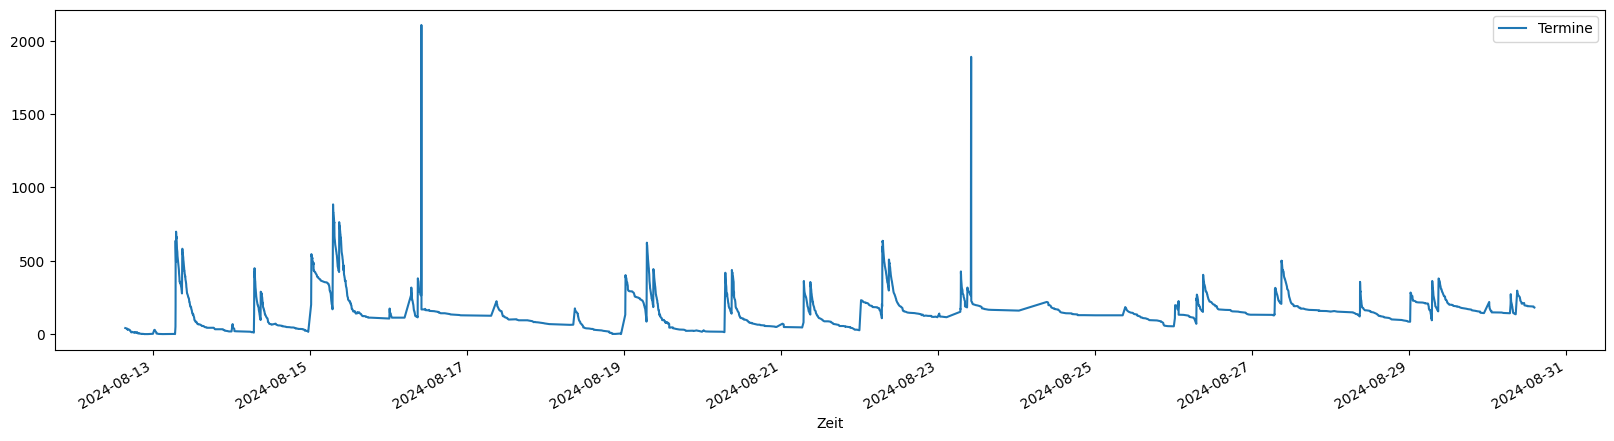

In [95]:
# alle Termine in Düsseldorf

df_city = df[df["stadt"] == "Duesseldorf"]  # 14 323 Termine

# sortiere aufsteigend nach belegt-Zeitpunkt

timestamps = df_city["belegt"].sort_values().unique()


count_open_per_timestamp = []

for timestamp in timestamps:

    # pro Zeitpunkt: wie viele Termine sind offen?
    # Termine sind zu einem Zeitpunkt offen, wenn ...
    count = df_city[
        # - der Anlegezeitpunkt vor (oder auf) dem Zeitpunkt liegt und ...
        (df_city["angelegt"] <= timestamp)
        # - der Belegtzeitpunkt entweder nach dem Zeitpunkt liegt oder gar nicht gesetzt ist
        & ((timestamp < df_city["belegt"]) | (df_city["belegt"].isnull()))
    ].shape[0]
    count_open_per_timestamp.append(count)

open = pd.DataFrame({"Zeit": timestamps, "Termine": count_open_per_timestamp})

# plotte die Anzahl der offenen Termine pro belegt-Zeitpunkt
open.plot(x="Zeit", y="Termine", kind="line", figsize=(20, 5))

plt.show()

<Axes: xlabel='Zeit'>

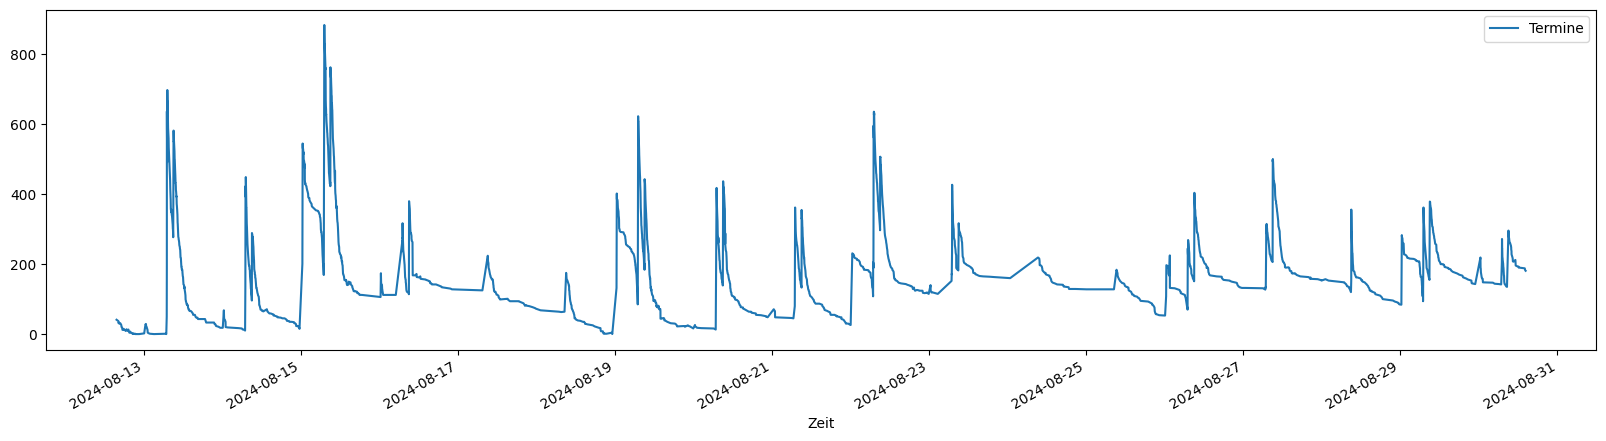

In [96]:
# outliers entfernen
open = open[open["Termine"] < 1000]

open.plot(x="Zeit", y="Termine", kind="line", figsize=(20, 5))

<Axes: xlabel='Zeit'>

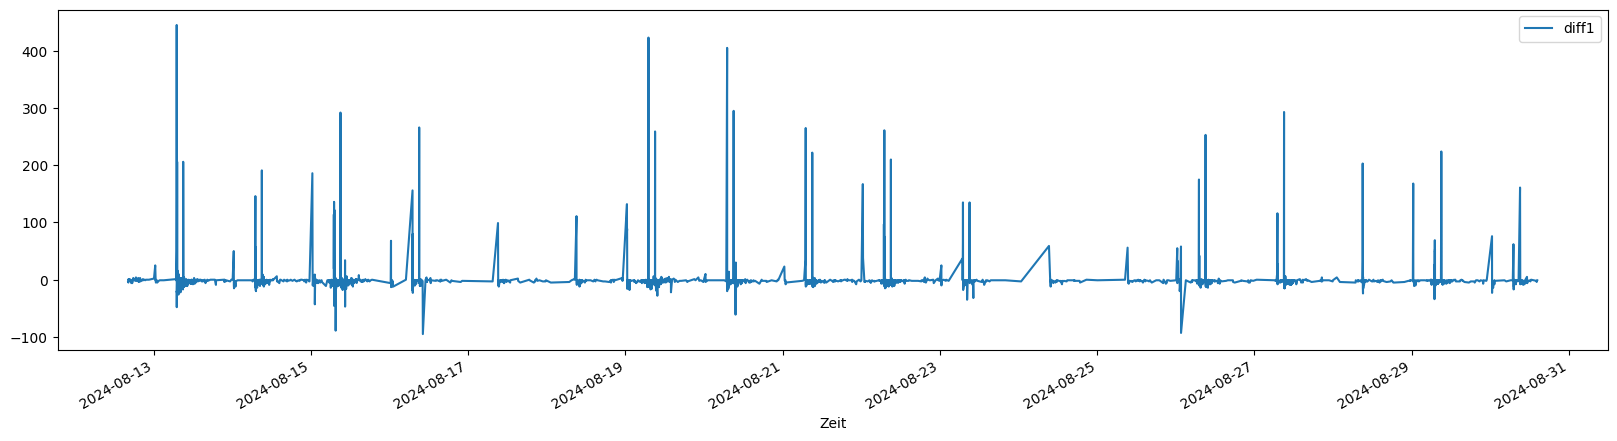

In [97]:
# differencing after lag of 1
open["diff1"] = open["Termine"].diff(1)

open.plot(x="Zeit", y="diff1", kind="line", figsize=(20, 5))

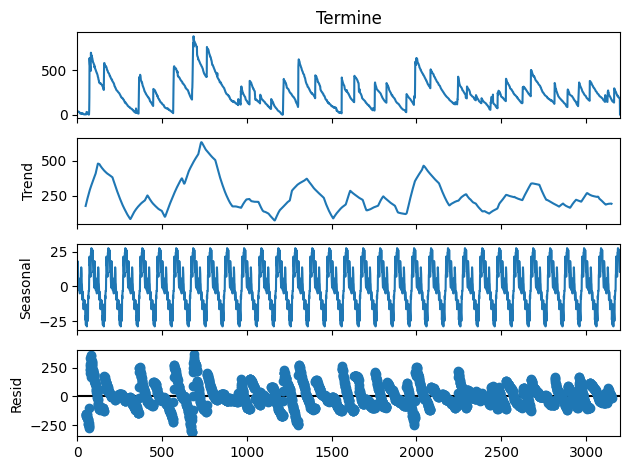

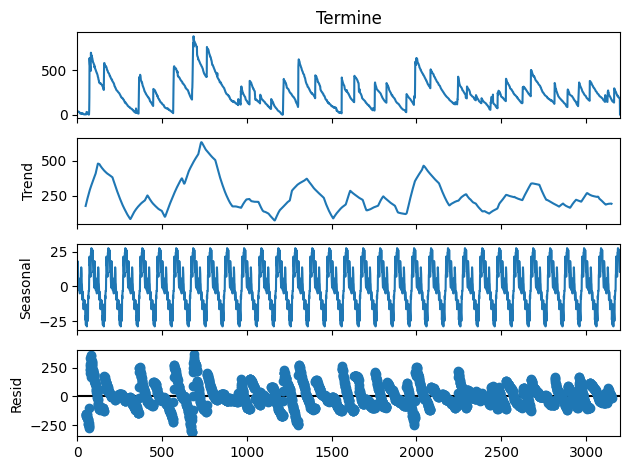

In [141]:
sm.tsa.seasonal_decompose(open["Termine"], model="additive", period=100).plot()

In [142]:
df_city_time_until = df_city["datum"] - df_city["angelegt"]
df_city_time_until.describe()

count                        16699
mean     8 days 05:36:41.163348703
std      8 days 06:00:32.729239754
min         0 days 00:04:47.479802
25%         0 days 07:07:48.875955
50%         4 days 10:41:28.001229
75%        16 days 22:15:24.202997
max        21 days 08:43:48.365768
dtype: object

In [143]:
df_city_time_open = df_city["belegt"] - df_city["angelegt"]
df_city_time_open.describe()

count                        16518
mean     0 days 03:21:15.905946882
std      0 days 11:01:21.295820814
min         0 days 00:00:26.531801
25%         0 days 00:02:00.329266
50%         0 days 00:27:01.129955
75%         0 days 01:58:04.836013
max         4 days 13:03:41.429315
dtype: object

In [144]:
df_city_time_until

2891     0 days 17:24:17.965138
2892     0 days 17:29:17.965138
2893     1 days 19:34:17.965138
2894     1 days 19:39:17.965138
2895    20 days 15:54:17.965138
                  ...          
43749    6 days 04:23:06.784666
43750    6 days 04:28:06.784666
43751    6 days 04:33:06.784666
43752    6 days 04:38:06.784666
43794   13 days 02:35:03.563516
Length: 16699, dtype: timedelta64[ns]

<Axes: ylabel='Frequency'>

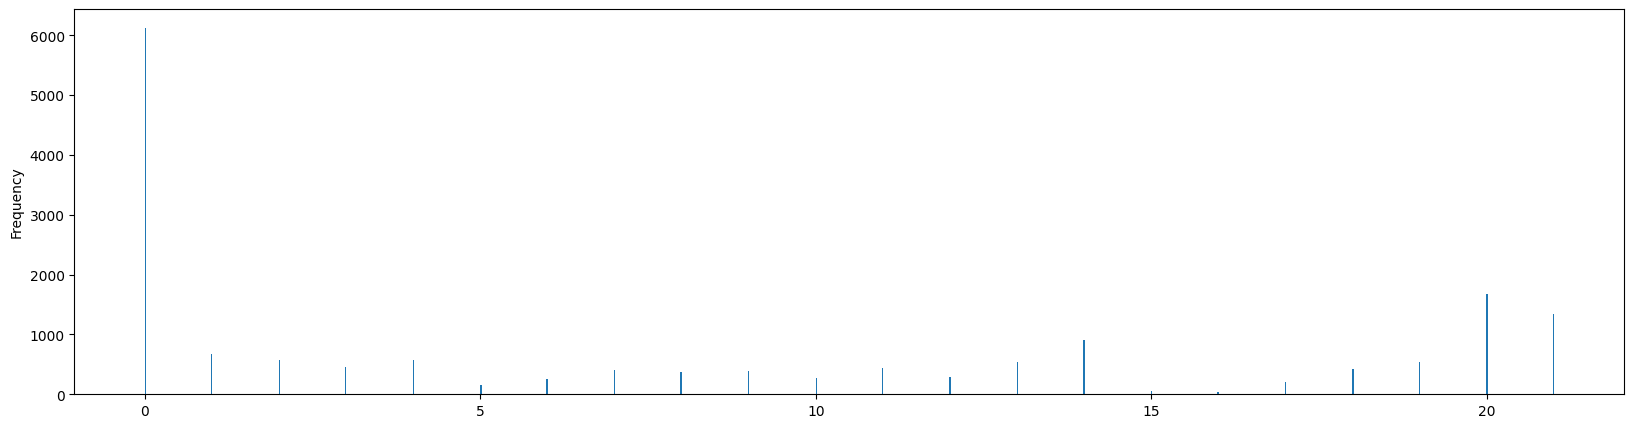

In [145]:
# histogramm der Zeit bis zum Termin
df_city_time_until.dt.days.plot.hist(bins=1000, figsize=(20, 5))